In [1]:
#Problem Setup/Definition:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.prediction_algorithms import predictions
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise import KNNWithMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
##################################
## Import Movie Ratings Dataset ##
##################################
rawMovieData = pd.read_csv('ml-latest-small/ratings.csv')
# Use suprise  Dataset Library: https://surprise.readthedocs.io/en/stable/dataset.html
# Reader Class: https://surprise.readthedocs.io/en/stable/reader.html
# Defaults are set to: user, item, rating
reader = Reader()
movieRatingsDataset = Dataset.load_from_df(rawMovieData[['userId', 'movieId', 'rating']], reader)
movieRatingsDataFrame = movieRatingsDataset.df
movieRatingsListTuples = movieRatingsDataset.raw_ratings

## Question 35

Answer in report

## Question 36

In [3]:
# Drop any users that have less than ratings than 'numberRecommend'
# Drop any users that have no ratings above the 'threshold' (They dont like anything)
def RemoveUsers(testdataset, threshold, numberRecommend):
    
    allUserDataMap = defaultdict(list)
    
    # dataTuple: (UserID, movieID, true_rating)
    # Create a Mapping of 'userID':[[movieId, trueRating],...]
    for dataTuple in testdataset:
        
        userID = dataTuple[0]
        movieID = dataTuple[1]
        trueRating = dataTuple[2]
        
        allUserDataMap[str(userID)].append([movieID, trueRating])
        
    ################################################################
    # Drop users who havent rated enough movies 'numberRecommend' ##
    ################################################################
    
    print("# Users BEFORE trim: " + str(len(allUserDataMap)))
    allUserDataMap = {userId:moveList for userId, moveList in allUserDataMap.items() if len(moveList) >= numberRecommend}
    print("# Users after trim (Less than " + str(numberRecommend) + " movies rated): " + str(len(allUserDataMap)))

    #####################################################
    # Drop users who have no ratings above 'threshold' ##
    #####################################################
    # Create list of users that need to be deleted.
    deleteList = []
    for users, movieList in allUserDataMap.items():
        likedCounter = 0
        # Iterate over all movies rated by a specific user
        for movie in range(len(movieList)):
            # Check if 'trueRating' > threshhold, increment 'likedCounter'
            if movieList[movie][1] > threshold:
                likedCounter += 1
        
        # If total number of 'likedCounter' movies = 0, add to deleteList
        if likedCounter == 0:
            deleteList.append(users)
    
    # Delete all users on 'deleteList'
    for deleteUsers in deleteList:
        del allUserDataMap[deleteUsers]
    
    print("# Users after trim (zero ratings above " + str(threshold) + "): " + str(len(allUserDataMap)))
    
    #######################################
    # Convert back to testdataset format ##
    #######################################
    trimmedTestDataSet = []
    
    # Iterate over all entries in dictionary, convert to list of tuples
    for users, movieList in allUserDataMap.items():
        for movies in range(len(movieList)):
            
            # Defined testDataSet Tuple entries (userId, movieId, rating)
            userId = int(users)
            movieId = movieList[movies][0]
            rating = movieList[movies][1]
            dataTuple = (userId, movieId, rating)
            
            # append each item into final tuple()-list[]
            trimmedTestDataSet.append(dataTuple)
    
    return trimmedTestDataSet

In [4]:
def PrecisionRecall(predictionList, threshold, numberRecommend):
    
    # defaultdict is like a dictionary{} with built in key values (No Key Errors)
    userPredictionMap = defaultdict(list)
    userPrecisionList = []
    userRecallList = []
    
    # Calculate relevant movies (per user)
    # Dictionary{'userId':[estimated_rating, true_rating]}
    # predictionObjects: uid=userId, iid=movieId, r_ui=true_rating, est=predicted_rating, details={'was_impossible': False}
    for predictionObject in predictionList:
        
        # Break down predictionObject() into individual values 
        userID = predictionObject.uid
        predictedRating = predictionObject.est
        trueRating = predictionObject.r_ui

        # Hashmap of 'userId' :[[predictedRating, trueRating],...]
        userPredictionMap[str(userID)].append([predictedRating,trueRating])
    
        # Sort the predicted movies for each user in descending order
        for users, movieList in userPredictionMap.items():
            
            # users: <string> userId
            # movieList: <list> [[predictedRating, trueRating],...] 
            
            # Sort the movieList of each user in place (high-Low)
            movieList.sort(key=lambda movie: movie[0], reverse=True)

    ##############################
    # Calculate 'True Positives'##
    ##############################

    # Iterate over each userId
    for users, movieList in userPredictionMap.items():
 
        ###############################################################
        # Calculate S(t) Interect G: Number of items rated correctly ##
        ###############################################################

        # Iterate over each movie list [estimated_rating, true_rating] belonging to that userId
        # Only take up to the size of the recommendation list 'numberRecommend'
        truePositiveRecs = 0
        for movies in range(numberRecommend):
            # Count number of movies each userId has rated above the threshold (real_rating)
            if movieList[movies][1] >= threshold:
                    truePositiveRecs += 1
    
        ################################################
        # Calculate S(t): Number of recommended items ##
        ################################################

        numberRecommend = numberRecommend
    
        ########################################################
        # Calculate G: Number of true_ratings above threshold ##
        ########################################################

        trueRatingsAboveThreshold = 0
        # Iterate over each movie list [estimated_rating, true_rating] belonging to that userId
        # count number of movies that the user actually rates (true_rating) above threshold.
        for movies in range(len(movieList)):
            if movieList[movies][1] >= threshold:
                trueRatingsAboveThreshold += 1

        #################################
        # Calculate Precision & Recall ##
        #################################

        userPrecision = truePositiveRecs/numberRecommend
        userRecall = truePositiveRecs/trueRatingsAboveThreshold
    
        userPrecisionList.append(userPrecision)
        userRecallList.append(userRecall)
        
#        print("This user's precision: " + str(userPrecision))
#        print("This user's recall: " + str(userRecall))

        
    # Calculate the average precision/recall over ALL users in this testset.
    avgPrecision = np.mean(userPrecisionList)
    avgRecall = np.mean(userRecallList)
    
#    print("Average precision over all users: " + str(avgPrecision))
#    print("Average recall over all users: " + str(avgRecall))

    return avgPrecision, avgRecall
    

In [5]:
def SweepPrecisionRecall(model, k_fold, mthreshold): 
    # Define t values: Top rankings
    tRank = list(range(1,26))

    # Accuracy and Recall
    avgPrecisionList = []
    avgRecallList= []

    # Iterate over all 25 ranking values
    for rankValue in tRank:

        precisionList10 = []
        recallList10 = []
        kFoldCounter = 1
        # Assuming we need 10 Fold cross validation
        for traindataset, testdataset in KFold(n_splits=k_fold).split(movieRatingsDataset):

            # Train the Model
            model.fit(traindataset)

            # Trim testdataset
            trimmedTestDataset = RemoveUsers(testdataset, threshold=mthreshold, numberRecommend=rankValue)

            # Make Predictions
            predictionObjectList = model.test(trimmedTestDataset)

            # Calculate Precision/Recall
            precision, recall = PrecisionRecall(predictionObjectList, threshold=mthreshold, numberRecommend=rankValue)

            # Store the calculated precision & recall
            precisionList10.append(precision)
            recallList10.append(recall)

            # Print intermediate results
            print("The calculated Precision in this K-Fold run " + str(kFoldCounter) + "/10: " + str(precision))
            print("The calculated Recall in this K-Fold run " + str(kFoldCounter) + "/10: " + str(recall))
            print("\n"+"="*40+"\n")
            kFoldCounter += 1

        # Average recall/precision over the 10 K-fold runs. 
        # Append to averageList[]
        avgPrecisionList.append(np.mean(precisionList10))
        avgRecallList.append(np.mean(recallList10))
        print("The Average Precision in this t_value run " + str(rankValue) + "/25: " + str(np.mean(precisionList10)))
        print("The Average Recall in this t_value run " + str(rankValue) + "/25: " + str(np.mean(recallList10)))
        print("\n"+"="*40+"\n")
    
    return avgPrecisionList, avgRecallList


In [6]:
#################
## KNN RANKING ##
#################
# Define KNN Model: K_value from Question 11 = 24
k=24
knnSimilarities = {'name':'pearson', 'user_based':True}
knnModel = KNNWithMeans(k=k, sim_options=knnSimilarities)

knnPrecisionList, knnRecallList = SweepPrecisionRecall(model=knnModel, k_fold=10, mthreshold=3)

Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 601
# Users after trim (Less than 1 movies rated): 601
# Users after trim (zero ratings above 3): 564
The calculated Precision in this K-Fold run 1/10: 0.9397163120567376
The calculated Recall in this K-Fold run 1/10: 0.2143832019739961


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 602
# Users after trim (Less than 1 movies rated): 602
# Users after trim (zero ratings above 3): 562
The calculated Precision in this K-Fold run 2/10: 0.9306049822064056
The calculated Recall in this K-Fold run 2/10: 0.19744881552944732


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 600
# Users after trim (Less than 1 movies rated): 600
# Users after trim (zero ratings above 3): 566
The calculated Precision in this K-Fold run 3/10: 0.9328621908127208
The calculated Recall in this K-Fold run 3/10: 0.1995288

Done computing similarity matrix.
# Users BEFORE trim: 597
# Users after trim (Less than 3 movies rated): 504
# Users after trim (zero ratings above 3): 493
The calculated Precision in this K-Fold run 2/10: 0.9181879648411088
The calculated Recall in this K-Fold run 2/10: 0.3961547591931041


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 603
# Users after trim (Less than 3 movies rated): 507
# Users after trim (zero ratings above 3): 498
The calculated Precision in this K-Fold run 3/10: 0.9203480589022758
The calculated Recall in this K-Fold run 3/10: 0.4114368919358988


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 599
# Users after trim (Less than 3 movies rated): 513
# Users after trim (zero ratings above 3): 495
The calculated Precision in this K-Fold run 4/10: 0.9151515151515152
The calculated Recall in this K-Fold run 4/10: 0.40069969275806583


Computing the pearson similarit

Done computing similarity matrix.
# Users BEFORE trim: 598
# Users after trim (Less than 5 movies rated): 397
# Users after trim (zero ratings above 3): 390
The calculated Precision in this K-Fold run 3/10: 0.922051282051282
The calculated Recall in this K-Fold run 3/10: 0.47455394073528173


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 598
# Users after trim (Less than 5 movies rated): 411
# Users after trim (zero ratings above 3): 407
The calculated Precision in this K-Fold run 4/10: 0.9071253071253071
The calculated Recall in this K-Fold run 4/10: 0.46422559467055685


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 601
# Users after trim (Less than 5 movies rated): 405
# Users after trim (zero ratings above 3): 405
The calculated Precision in this K-Fold run 5/10: 0.9091358024691357
The calculated Recall in this K-Fold run 5/10: 0.46510083385501994


Computing the pearson similari

Done computing similarity matrix.
# Users BEFORE trim: 601
# Users after trim (Less than 7 movies rated): 327
# Users after trim (zero ratings above 3): 325
The calculated Precision in this K-Fold run 4/10: 0.9134065934065934
The calculated Recall in this K-Fold run 4/10: 0.49671950506569507


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 602
# Users after trim (Less than 7 movies rated): 327
# Users after trim (zero ratings above 3): 327
The calculated Precision in this K-Fold run 5/10: 0.9204892966360856
The calculated Recall in this K-Fold run 5/10: 0.5039088457524308


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 599
# Users after trim (Less than 7 movies rated): 330
# Users after trim (zero ratings above 3): 330
The calculated Precision in this K-Fold run 6/10: 0.9086580086580087
The calculated Recall in this K-Fold run 6/10: 0.4989704039964494


Computing the pearson similarit

Done computing similarity matrix.
# Users BEFORE trim: 595
# Users after trim (Less than 9 movies rated): 279
# Users after trim (zero ratings above 3): 278
The calculated Precision in this K-Fold run 5/10: 0.9020783373301358
The calculated Recall in this K-Fold run 5/10: 0.5213085320978641


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 597
# Users after trim (Less than 9 movies rated): 276
# Users after trim (zero ratings above 3): 276
The calculated Precision in this K-Fold run 6/10: 0.9025764895330114
The calculated Recall in this K-Fold run 6/10: 0.5259403288333285


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 600
# Users after trim (Less than 9 movies rated): 273
# Users after trim (zero ratings above 3): 271
The calculated Precision in this K-Fold run 7/10: 0.901189011890119
The calculated Recall in this K-Fold run 7/10: 0.5222605046681464


Computing the pearson similarity 

Done computing similarity matrix.
# Users BEFORE trim: 598
# Users after trim (Less than 11 movies rated): 249
# Users after trim (zero ratings above 3): 249
The calculated Precision in this K-Fold run 6/10: 0.8966776195691858
The calculated Recall in this K-Fold run 6/10: 0.561870146078001


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 599
# Users after trim (Less than 11 movies rated): 230
# Users after trim (zero ratings above 3): 230
The calculated Precision in this K-Fold run 7/10: 0.9039525691699604
The calculated Recall in this K-Fold run 7/10: 0.536692309541699


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 602
# Users after trim (Less than 11 movies rated): 241
# Users after trim (zero ratings above 3): 241
The calculated Precision in this K-Fold run 8/10: 0.907959260656356
The calculated Recall in this K-Fold run 8/10: 0.5425349025294961


Computing the pearson similarity

Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 598
# Users after trim (Less than 13 movies rated): 199
# Users after trim (zero ratings above 3): 199
The calculated Precision in this K-Fold run 7/10: 0.885195206803247
The calculated Recall in this K-Fold run 7/10: 0.5482327169634063


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 596
# Users after trim (Less than 13 movies rated): 202
# Users after trim (zero ratings above 3): 202
The calculated Precision in this K-Fold run 8/10: 0.9044173648134045
The calculated Recall in this K-Fold run 8/10: 0.5506013875255714


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 604
# Users after trim (Less than 13 movies rated): 205
# Users after trim (zero ratings above 3): 205
The calculated Precision in this K-Fold run 9/10: 0.90281425891182
The calculated Recall in this K-Fold run 9/10: 0.55471983

Done computing similarity matrix.
# Users BEFORE trim: 601
# Users after trim (Less than 15 movies rated): 179
# Users after trim (zero ratings above 3): 178
The calculated Precision in this K-Fold run 8/10: 0.9022471910112361
The calculated Recall in this K-Fold run 8/10: 0.5689166316886078


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 593
# Users after trim (Less than 15 movies rated): 183
# Users after trim (zero ratings above 3): 183
The calculated Precision in this K-Fold run 9/10: 0.897632058287796
The calculated Recall in this K-Fold run 9/10: 0.5732977738256534


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 597
# Users after trim (Less than 15 movies rated): 179
# Users after trim (zero ratings above 3): 178
The calculated Precision in this K-Fold run 10/10: 0.8932584269662921
The calculated Recall in this K-Fold run 10/10: 0.557276348558477


The Average Precision in this

Done computing similarity matrix.
# Users BEFORE trim: 593
# Users after trim (Less than 17 movies rated): 163
# Users after trim (zero ratings above 3): 163
The calculated Precision in this K-Fold run 9/10: 0.8942619992782388
The calculated Recall in this K-Fold run 9/10: 0.5775724442343702


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 600
# Users after trim (Less than 17 movies rated): 154
# Users after trim (zero ratings above 3): 154
The calculated Precision in this K-Fold run 10/10: 0.8911382734912145
The calculated Recall in this K-Fold run 10/10: 0.5696997401380174


The Average Precision in this t_value run 17/25: 0.8941147172160291
The Average Recall in this t_value run 17/25: 0.5812918484282047


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 601
# Users after trim (Less than 18 movies rated): 155
# Users after trim (zero ratings above 3): 155
The calculated Precision in t

Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 599
# Users after trim (Less than 19 movies rated): 146
# Users after trim (zero ratings above 3): 146
The calculated Precision in this K-Fold run 10/10: 0.8907714491708724
The calculated Recall in this K-Fold run 10/10: 0.5949760210105528


The Average Precision in this t_value run 19/25: 0.8929095759100522
The Average Recall in this t_value run 19/25: 0.5934779006865243


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 592
# Users after trim (Less than 20 movies rated): 138
# Users after trim (zero ratings above 3): 138
The calculated Precision in this K-Fold run 1/10: 0.8992753623188405
The calculated Recall in this K-Fold run 1/10: 0.6034715263123712


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 593
# Users after trim (Less than 20 movies rated): 132
# Users after trim (zero ratings 

Done computing similarity matrix.
# Users BEFORE trim: 595
# Users after trim (Less than 22 movies rated): 125
# Users after trim (zero ratings above 3): 125
The calculated Precision in this K-Fold run 1/10: 0.8814545454545454
The calculated Recall in this K-Fold run 1/10: 0.6025335487761697


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 601
# Users after trim (Less than 22 movies rated): 130
# Users after trim (zero ratings above 3): 130
The calculated Precision in this K-Fold run 2/10: 0.8769230769230769
The calculated Recall in this K-Fold run 2/10: 0.6164298495152625


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 598
# Users after trim (Less than 22 movies rated): 124
# Users after trim (zero ratings above 3): 124
The calculated Precision in this K-Fold run 3/10: 0.8870967741935484
The calculated Recall in this K-Fold run 3/10: 0.6098926298640329


Computing the pearson similar

Done computing similarity matrix.
# Users BEFORE trim: 589
# Users after trim (Less than 24 movies rated): 118
# Users after trim (zero ratings above 3): 118
The calculated Precision in this K-Fold run 2/10: 0.8732344632768363
The calculated Recall in this K-Fold run 2/10: 0.613945657477733


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 594
# Users after trim (Less than 24 movies rated): 116
# Users after trim (zero ratings above 3): 116
The calculated Precision in this K-Fold run 3/10: 0.8821839080459771
The calculated Recall in this K-Fold run 3/10: 0.6225571680987982


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 602
# Users after trim (Less than 24 movies rated): 114
# Users after trim (zero ratings above 3): 114
The calculated Precision in this K-Fold run 4/10: 0.8932748538011696
The calculated Recall in this K-Fold run 4/10: 0.6151040788300052


Computing the pearson similari

Average Precision over 10-Folds:
Threshold: 1/25: 0.9318513075639577
Threshold: 2/25: 0.9209835960491881
Threshold: 3/25: 0.9181445330118592
Threshold: 4/25: 0.9157612304013003
Threshold: 5/25: 0.9132917943527383
Threshold: 6/25: 0.9090327675145261
Threshold: 7/25: 0.908844389441323
Threshold: 8/25: 0.9046410705862309
Threshold: 9/25: 0.9019898093285903
Threshold: 10/25: 0.9004438107900279
Threshold: 11/25: 0.8998404867740939
Threshold: 12/25: 0.8975393845102493
Threshold: 13/25: 0.898554059206304
Threshold: 14/25: 0.8973677770293411
Threshold: 15/25: 0.8962484949951991
Threshold: 16/25: 0.896920781389779
Threshold: 17/25: 0.8941147172160291
Threshold: 18/25: 0.8911998914715987
Threshold: 19/25: 0.8929095759100522
Threshold: 20/25: 0.8900941571219301
Threshold: 21/25: 0.8868946425422106
Threshold: 22/25: 0.8845842604508535
Threshold: 23/25: 0.8819286498209475
Threshold: 24/25: 0.8800274456612815
Threshold: 25/25: 0.8806659601521323


Text(0, 0.5, 'Precision over 10 K-folds')

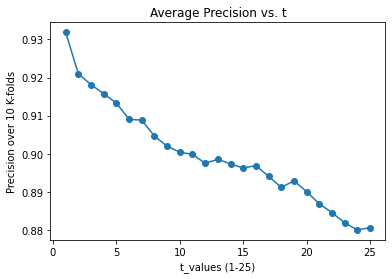

In [7]:
#######################
## KNN Precision Plot #
#######################
print("Average Precision over 10-Folds:")
for prec in range(len(knnPrecisionList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(knnPrecisionList[prec]))

t_value = range(1,26)
plt.plot(t_value, knnPrecisionList, marker='o')
plt.title("Average Precision vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision over 10 K-folds")

Average Recall over 10-Folds:
Threshold: 1/25: 0.20464642765253888
Threshold: 2/25: 0.3412518400955892
Threshold: 3/25: 0.4072918581932107
Threshold: 4/25: 0.4438778227652797
Threshold: 5/25: 0.4705368437032652
Threshold: 6/25: 0.48400750739928766
Threshold: 7/25: 0.49446063869077816
Threshold: 8/25: 0.5116669146083025
Threshold: 9/25: 0.5210164837750705
Threshold: 10/25: 0.5298176472890084
Threshold: 11/25: 0.5433565976204869
Threshold: 12/25: 0.5451728339193033
Threshold: 13/25: 0.5572630516903324
Threshold: 14/25: 0.5649876483204032
Threshold: 15/25: 0.5656489435560681
Threshold: 16/25: 0.5795243443417162
Threshold: 17/25: 0.5812918484282047
Threshold: 18/25: 0.5838897498567259
Threshold: 19/25: 0.5934779006865243
Threshold: 20/25: 0.5921375422350729
Threshold: 21/25: 0.5956694071884061
Threshold: 22/25: 0.6121508817929417
Threshold: 23/25: 0.6092011497941303
Threshold: 24/25: 0.6168578057567987
Threshold: 25/25: 0.6195938995892643


Text(0, 0.5, 'Recall over 10 K-folds')

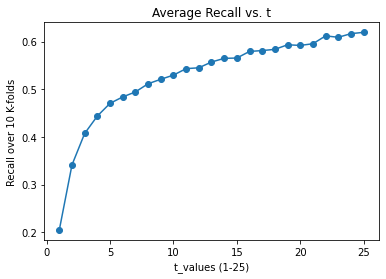

In [8]:
####################
## KNN Recall Plot #
####################
print("Average Recall over 10-Folds:")
for prec in range(len(knnRecallList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(knnRecallList[prec]))

t_value = range(1,26)
plt.plot(t_value, knnRecallList, marker='o')
plt.title("Average Recall vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")

Knn Precision vs. Recall over 10-Folds:


Text(0, 0.5, 'Precision')

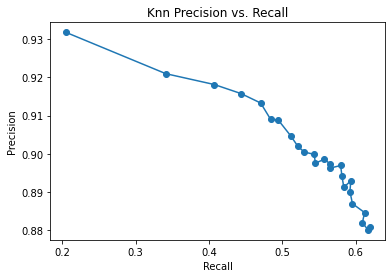

In [9]:
##################################
## KNN Prceision vs. Recall Plot #
##################################
print("Knn Precision vs. Recall over 10-Folds:")

t_value = range(1,26)
plt.plot(knnRecallList, knnPrecisionList, marker='o')
plt.title("Knn Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Question 37

In [10]:
#################
## NMF RANKING ##
#################
# Define NMF Model: K_value from Question 18 = 14
k=14
nmfModel = NMF(n_factors=k)
nmfPrecisionList, nmfRecallList = SweepPrecisionRecall(model=nmfModel, k_fold=10, mthreshold=3)

# Users BEFORE trim: 589
# Users after trim (Less than 1 movies rated): 589
# Users after trim (zero ratings above 3): 565
The calculated Precision in this K-Fold run 1/10: 0.9309734513274336
The calculated Recall in this K-Fold run 1/10: 0.19582953165139733


# Users BEFORE trim: 599
# Users after trim (Less than 1 movies rated): 599
# Users after trim (zero ratings above 3): 563
The calculated Precision in this K-Fold run 2/10: 0.9236234458259325
The calculated Recall in this K-Fold run 2/10: 0.20455260830341154


# Users BEFORE trim: 595
# Users after trim (Less than 1 movies rated): 595
# Users after trim (zero ratings above 3): 561
The calculated Precision in this K-Fold run 3/10: 0.9376114081996435
The calculated Recall in this K-Fold run 3/10: 0.2030263140936805


# Users BEFORE trim: 603
# Users after trim (Less than 1 movies rated): 603
# Users after trim (zero ratings above 3): 569
The calculated Precision in this K-Fold run 4/10: 0.9384885764499121
The calculated Recall in t

The calculated Precision in this K-Fold run 7/10: 0.9108449767132402
The calculated Recall in this K-Fold run 7/10: 0.4014058688322613


# Users BEFORE trim: 602
# Users after trim (Less than 3 movies rated): 506
# Users after trim (zero ratings above 3): 493
The calculated Precision in this K-Fold run 8/10: 0.9276538201487491
The calculated Recall in this K-Fold run 8/10: 0.4054396210144201


# Users BEFORE trim: 598
# Users after trim (Less than 3 movies rated): 512
# Users after trim (zero ratings above 3): 505
The calculated Precision in this K-Fold run 9/10: 0.9095709570957096
The calculated Recall in this K-Fold run 9/10: 0.3977849971324054


# Users BEFORE trim: 600
# Users after trim (Less than 3 movies rated): 510
# Users after trim (zero ratings above 3): 495
The calculated Precision in this K-Fold run 10/10: 0.9151515151515152
The calculated Recall in this K-Fold run 10/10: 0.3979398848877582


The Average Precision in this t_value run 3/25: 0.9140284186424308
The Average Re

# Users BEFORE trim: 599
# Users after trim (Less than 6 movies rated): 367
# Users after trim (zero ratings above 3): 365
The calculated Precision in this K-Fold run 3/10: 0.9022831050228312
The calculated Recall in this K-Fold run 3/10: 0.4755116300274273


# Users BEFORE trim: 602
# Users after trim (Less than 6 movies rated): 365
# Users after trim (zero ratings above 3): 364
The calculated Precision in this K-Fold run 4/10: 0.9084249084249085
The calculated Recall in this K-Fold run 4/10: 0.4842184690067365


# Users BEFORE trim: 598
# Users after trim (Less than 6 movies rated): 359
# Users after trim (zero ratings above 3): 359
The calculated Precision in this K-Fold run 5/10: 0.8983286908077994
The calculated Recall in this K-Fold run 5/10: 0.4696673529583396


# Users BEFORE trim: 600
# Users after trim (Less than 6 movies rated): 354
# Users after trim (zero ratings above 3): 352
The calculated Precision in this K-Fold run 6/10: 0.909564393939394
The calculated Recall in this

The calculated Precision in this K-Fold run 9/10: 0.8941993464052288
The calculated Recall in this K-Fold run 9/10: 0.529190030786968


# Users BEFORE trim: 598
# Users after trim (Less than 8 movies rated): 298
# Users after trim (zero ratings above 3): 298
The calculated Precision in this K-Fold run 10/10: 0.9010067114093959
The calculated Recall in this K-Fold run 10/10: 0.5062444816721653


The Average Precision in this t_value run 8/25: 0.8997594928115973
The Average Recall in this t_value run 8/25: 0.510548858412754


# Users BEFORE trim: 597
# Users after trim (Less than 9 movies rated): 289
# Users after trim (zero ratings above 3): 288
The calculated Precision in this K-Fold run 1/10: 0.8858024691358024
The calculated Recall in this K-Fold run 1/10: 0.5318710251111871


# Users BEFORE trim: 595
# Users after trim (Less than 9 movies rated): 277
# Users after trim (zero ratings above 3): 277
The calculated Precision in this K-Fold run 2/10: 0.9025270758122743
The calculated Rec

# Users BEFORE trim: 596
# Users after trim (Less than 11 movies rated): 233
# Users after trim (zero ratings above 3): 233
The calculated Precision in this K-Fold run 5/10: 0.8888021849395239
The calculated Recall in this K-Fold run 5/10: 0.5352565891985033


# Users BEFORE trim: 595
# Users after trim (Less than 11 movies rated): 238
# Users after trim (zero ratings above 3): 237
The calculated Precision in this K-Fold run 6/10: 0.8945147679324894
The calculated Recall in this K-Fold run 6/10: 0.549482859835358


# Users BEFORE trim: 598
# Users after trim (Less than 11 movies rated): 232
# Users after trim (zero ratings above 3): 231
The calculated Precision in this K-Fold run 7/10: 0.8925619834710743
The calculated Recall in this K-Fold run 7/10: 0.5250950967032476


# Users BEFORE trim: 596
# Users after trim (Less than 11 movies rated): 232
# Users after trim (zero ratings above 3): 231
The calculated Precision in this K-Fold run 8/10: 0.8945297127115308
The calculated Recall in 

# Users BEFORE trim: 597
# Users after trim (Less than 14 movies rated): 193
# Users after trim (zero ratings above 3): 193
The calculated Precision in this K-Fold run 1/10: 0.8993338267949668
The calculated Recall in this K-Fold run 1/10: 0.5629538498706536


# Users BEFORE trim: 601
# Users after trim (Less than 14 movies rated): 199
# Users after trim (zero ratings above 3): 199
The calculated Precision in this K-Fold run 2/10: 0.8951902368987797
The calculated Recall in this K-Fold run 2/10: 0.5772601709370473


# Users BEFORE trim: 602
# Users after trim (Less than 14 movies rated): 194
# Users after trim (zero ratings above 3): 194
The calculated Precision in this K-Fold run 3/10: 0.8869661266568484
The calculated Recall in this K-Fold run 3/10: 0.557866731326118


# Users BEFORE trim: 601
# Users after trim (Less than 14 movies rated): 192
# Users after trim (zero ratings above 3): 192
The calculated Precision in this K-Fold run 4/10: 0.9014136904761904
The calculated Recall in 

# Users BEFORE trim: 600
# Users after trim (Less than 16 movies rated): 168
# Users after trim (zero ratings above 3): 168
The calculated Precision in this K-Fold run 7/10: 0.8865327380952381
The calculated Recall in this K-Fold run 7/10: 0.5661070149242465


# Users BEFORE trim: 597
# Users after trim (Less than 16 movies rated): 173
# Users after trim (zero ratings above 3): 173
The calculated Precision in this K-Fold run 8/10: 0.8952312138728323
The calculated Recall in this K-Fold run 8/10: 0.571443597090232


# Users BEFORE trim: 597
# Users after trim (Less than 16 movies rated): 165
# Users after trim (zero ratings above 3): 165
The calculated Precision in this K-Fold run 9/10: 0.8837121212121212
The calculated Recall in this K-Fold run 9/10: 0.5667908614798255


# Users BEFORE trim: 606
# Users after trim (Less than 16 movies rated): 171
# Users after trim (zero ratings above 3): 171
The calculated Precision in this K-Fold run 10/10: 0.9016812865497076
The calculated Recall in

The calculated Precision in this K-Fold run 2/10: 0.8903811252268603
The calculated Recall in this K-Fold run 2/10: 0.591257826148563


# Users BEFORE trim: 599
# Users after trim (Less than 19 movies rated): 145
# Users after trim (zero ratings above 3): 145
The calculated Precision in this K-Fold run 3/10: 0.8929219600725952
The calculated Recall in this K-Fold run 3/10: 0.5940853869676911


# Users BEFORE trim: 598
# Users after trim (Less than 19 movies rated): 148
# Users after trim (zero ratings above 3): 148
The calculated Precision in this K-Fold run 4/10: 0.8847795163584637
The calculated Recall in this K-Fold run 4/10: 0.5856237585763674


# Users BEFORE trim: 599
# Users after trim (Less than 19 movies rated): 149
# Users after trim (zero ratings above 3): 149
The calculated Precision in this K-Fold run 5/10: 0.8717767573295655
The calculated Recall in this K-Fold run 5/10: 0.5941946461697551


# Users BEFORE trim: 598
# Users after trim (Less than 19 movies rated): 147
# Us

The calculated Precision in this K-Fold run 8/10: 0.8859357696566998
The calculated Recall in this K-Fold run 8/10: 0.5957639527526609


# Users BEFORE trim: 600
# Users after trim (Less than 21 movies rated): 127
# Users after trim (zero ratings above 3): 127
The calculated Precision in this K-Fold run 9/10: 0.8811398575178103
The calculated Recall in this K-Fold run 9/10: 0.5937279496429738


# Users BEFORE trim: 598
# Users after trim (Less than 21 movies rated): 134
# Users after trim (zero ratings above 3): 134
The calculated Precision in this K-Fold run 10/10: 0.8809523809523808
The calculated Recall in this K-Fold run 10/10: 0.6159689675756836


The Average Precision in this t_value run 21/25: 0.883156993057628
The Average Recall in this t_value run 21/25: 0.5988707733808599


# Users BEFORE trim: 595
# Users after trim (Less than 22 movies rated): 117
# Users after trim (zero ratings above 3): 117
The calculated Precision in this K-Fold run 1/10: 0.8931623931623932
The calculat

# Users BEFORE trim: 598
# Users after trim (Less than 24 movies rated): 111
# Users after trim (zero ratings above 3): 111
The calculated Precision in this K-Fold run 4/10: 0.8907657657657659
The calculated Recall in this K-Fold run 4/10: 0.6067455768974768


# Users BEFORE trim: 597
# Users after trim (Less than 24 movies rated): 114
# Users after trim (zero ratings above 3): 114
The calculated Precision in this K-Fold run 5/10: 0.8760964912280701
The calculated Recall in this K-Fold run 5/10: 0.6299837473793315


# Users BEFORE trim: 603
# Users after trim (Less than 24 movies rated): 108
# Users after trim (zero ratings above 3): 108
The calculated Precision in this K-Fold run 6/10: 0.8796296296296297
The calculated Recall in this K-Fold run 6/10: 0.6027620525745194


# Users BEFORE trim: 599
# Users after trim (Less than 24 movies rated): 113
# Users after trim (zero ratings above 3): 113
The calculated Precision in this K-Fold run 7/10: 0.8775811209439528
The calculated Recall in

Average Precision over 10-Folds:
Threshold: 1/25: 0.9340619218265169
Threshold: 2/25: 0.915031181871289
Threshold: 3/25: 0.9140284186424308
Threshold: 4/25: 0.9062696852438235
Threshold: 5/25: 0.9053620045757983
Threshold: 6/25: 0.9053308321532129
Threshold: 7/25: 0.900619796981213
Threshold: 8/25: 0.8997594928115973
Threshold: 9/25: 0.8959892313883004
Threshold: 10/25: 0.8979848178155303
Threshold: 11/25: 0.8969879063488362
Threshold: 12/25: 0.8950589378255375
Threshold: 13/25: 0.8932978069806344
Threshold: 14/25: 0.893299702082091
Threshold: 15/25: 0.8911367183474642
Threshold: 16/25: 0.8918987673298984
Threshold: 17/25: 0.8906993733733778
Threshold: 18/25: 0.8914543818173619
Threshold: 19/25: 0.8882916004500159
Threshold: 20/25: 0.8881361112800741
Threshold: 21/25: 0.883156993057628
Threshold: 22/25: 0.8836523175452313
Threshold: 23/25: 0.8807575377864701
Threshold: 24/25: 0.8808808752760019
Threshold: 25/25: 0.8781959161541412


Text(0, 0.5, 'Precision over 10 K-folds')

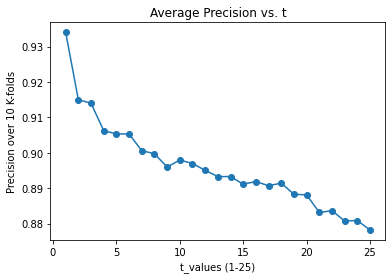

In [11]:
#######################
## NMF Precision Plot #
#######################
print("Average Precision over 10-Folds:")
for prec in range(len(nmfPrecisionList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(nmfPrecisionList[prec]))

t_value = range(1,26)
plt.plot(t_value, nmfPrecisionList, marker='o')
plt.title("Average Precision vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision over 10 K-folds")

Average Recall over 10-Folds:
Threshold: 1/25: 0.20621582052505566
Threshold: 2/25: 0.3371330268863469
Threshold: 3/25: 0.41015784438263053
Threshold: 4/25: 0.4431414339365368
Threshold: 5/25: 0.46082546528744706
Threshold: 6/25: 0.47907040748488416
Threshold: 7/25: 0.49107259475445614
Threshold: 8/25: 0.510548858412754
Threshold: 9/25: 0.5162392798746749
Threshold: 10/25: 0.5241694570392801
Threshold: 11/25: 0.5363613786573692
Threshold: 12/25: 0.5472300291125353
Threshold: 13/25: 0.5555601010915945
Threshold: 14/25: 0.56144894361753
Threshold: 15/25: 0.5683344486611426
Threshold: 16/25: 0.5695875745616914
Threshold: 17/25: 0.574574947400954
Threshold: 18/25: 0.587088650751275
Threshold: 19/25: 0.5864274255773768
Threshold: 20/25: 0.593939767317426
Threshold: 21/25: 0.5988707733808599
Threshold: 22/25: 0.6041822439565221
Threshold: 23/25: 0.6109038430896396
Threshold: 24/25: 0.6166582360276983
Threshold: 25/25: 0.6137778058637637


Text(0, 0.5, 'Recall over 10 K-folds')

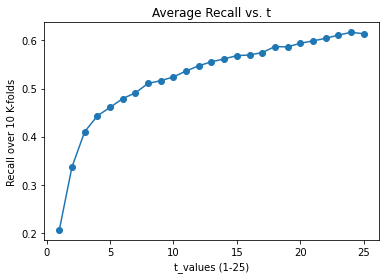

In [12]:
####################
## NMF Recall Plot #
####################
print("Average Recall over 10-Folds:")
for prec in range(len(nmfRecallList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(nmfRecallList[prec]))

t_value = range(1,26)
plt.plot(t_value, nmfRecallList, marker='o')
plt.title("Average Recall vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")

NNMF Precision vs. Recall over 10-Folds:


Text(0, 0.5, 'Precision')

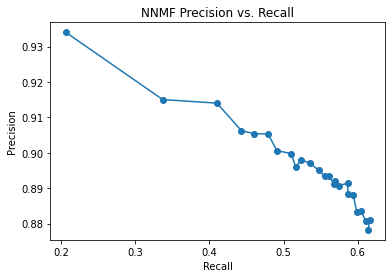

In [13]:
##################################
## NNMF Prceision vs. Recall Plot #
##################################
print("NNMF Precision vs. Recall over 10-Folds:")

t_value = range(1,26)
plt.plot(nmfRecallList, nmfPrecisionList, marker='o')
plt.title("NNMF Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Question 38

In [14]:
#####################
## MF-Bias RANKING ##
#####################
# Define MF-Bias Model: K_value from Question 25 = 40
k=40
svdModel = SVD(n_factors=k, biased=True)
svdPrecisionList, svdRecallList = SweepPrecisionRecall(model=svdModel, k_fold=10, mthreshold=3)

# Users BEFORE trim: 599
# Users after trim (Less than 1 movies rated): 599
# Users after trim (zero ratings above 3): 563
The calculated Precision in this K-Fold run 1/10: 0.9431616341030196
The calculated Recall in this K-Fold run 1/10: 0.21623918707922443


# Users BEFORE trim: 595
# Users after trim (Less than 1 movies rated): 595
# Users after trim (zero ratings above 3): 568
The calculated Precision in this K-Fold run 2/10: 0.9383802816901409
The calculated Recall in this K-Fold run 2/10: 0.20324383450876238


# Users BEFORE trim: 597
# Users after trim (Less than 1 movies rated): 597
# Users after trim (zero ratings above 3): 566
The calculated Precision in this K-Fold run 3/10: 0.9452296819787986
The calculated Recall in this K-Fold run 3/10: 0.20277726197235948


# Users BEFORE trim: 598
# Users after trim (Less than 1 movies rated): 598
# Users after trim (zero ratings above 3): 571
The calculated Precision in this K-Fold run 4/10: 0.9352014010507881
The calculated Recall in 

The calculated Precision in this K-Fold run 7/10: 0.9149933065595716
The calculated Recall in this K-Fold run 7/10: 0.40131299211791793


# Users BEFORE trim: 598
# Users after trim (Less than 3 movies rated): 514
# Users after trim (zero ratings above 3): 503
The calculated Precision in this K-Fold run 8/10: 0.9118621603711066
The calculated Recall in this K-Fold run 8/10: 0.40492956870222657


# Users BEFORE trim: 599
# Users after trim (Less than 3 movies rated): 517
# Users after trim (zero ratings above 3): 509
The calculated Precision in this K-Fold run 9/10: 0.9266535690897183
The calculated Recall in this K-Fold run 9/10: 0.42078903271676704


# Users BEFORE trim: 598
# Users after trim (Less than 3 movies rated): 504
# Users after trim (zero ratings above 3): 491
The calculated Precision in this K-Fold run 10/10: 0.9253224711473185
The calculated Recall in this K-Fold run 10/10: 0.4006929837397358


The Average Precision in this t_value run 3/25: 0.921204204734017
The Average 

# Users BEFORE trim: 592
# Users after trim (Less than 6 movies rated): 359
# Users after trim (zero ratings above 3): 354
The calculated Precision in this K-Fold run 3/10: 0.9100753295668549
The calculated Recall in this K-Fold run 3/10: 0.480331186490385


# Users BEFORE trim: 599
# Users after trim (Less than 6 movies rated): 353
# Users after trim (zero ratings above 3): 352
The calculated Precision in this K-Fold run 4/10: 0.9209280303030304
The calculated Recall in this K-Fold run 4/10: 0.4728459430717042


# Users BEFORE trim: 598
# Users after trim (Less than 6 movies rated): 361
# Users after trim (zero ratings above 3): 360
The calculated Precision in this K-Fold run 5/10: 0.9074074074074073
The calculated Recall in this K-Fold run 5/10: 0.4757317192193633


# Users BEFORE trim: 596
# Users after trim (Less than 6 movies rated): 354
# Users after trim (zero ratings above 3): 354
The calculated Precision in this K-Fold run 6/10: 0.9030131826741997
The calculated Recall in this

The calculated Precision in this K-Fold run 9/10: 0.8960437710437711
The calculated Recall in this K-Fold run 9/10: 0.506125367468765


# Users BEFORE trim: 597
# Users after trim (Less than 8 movies rated): 299
# Users after trim (zero ratings above 3): 299
The calculated Precision in this K-Fold run 10/10: 0.9126254180602007
The calculated Recall in this K-Fold run 10/10: 0.5072360777665565


The Average Precision in this t_value run 8/25: 0.9067029456663672
The Average Recall in this t_value run 8/25: 0.5062108030513464


# Users BEFORE trim: 599
# Users after trim (Less than 9 movies rated): 275
# Users after trim (zero ratings above 3): 273
The calculated Precision in this K-Fold run 1/10: 0.894993894993895
The calculated Recall in this K-Fold run 1/10: 0.5145935550028661


# Users BEFORE trim: 598
# Users after trim (Less than 9 movies rated): 284
# Users after trim (zero ratings above 3): 283
The calculated Precision in this K-Fold run 2/10: 0.9108755398508048
The calculated Rec

# Users BEFORE trim: 598
# Users after trim (Less than 11 movies rated): 247
# Users after trim (zero ratings above 3): 247
The calculated Precision in this K-Fold run 5/10: 0.9050423260949575
The calculated Recall in this K-Fold run 5/10: 0.5507984510881802


# Users BEFORE trim: 593
# Users after trim (Less than 11 movies rated): 251
# Users after trim (zero ratings above 3): 250
The calculated Precision in this K-Fold run 6/10: 0.9178181818181818
The calculated Recall in this K-Fold run 6/10: 0.5627910829345225


# Users BEFORE trim: 593
# Users after trim (Less than 11 movies rated): 237
# Users after trim (zero ratings above 3): 237
The calculated Precision in this K-Fold run 7/10: 0.899501342539317
The calculated Recall in this K-Fold run 7/10: 0.5501653094506884


# Users BEFORE trim: 598
# Users after trim (Less than 11 movies rated): 236
# Users after trim (zero ratings above 3): 236
The calculated Precision in this K-Fold run 8/10: 0.9010015408320493
The calculated Recall in 

# Users BEFORE trim: 598
# Users after trim (Less than 14 movies rated): 190
# Users after trim (zero ratings above 3): 190
The calculated Precision in this K-Fold run 1/10: 0.8924812030075188
The calculated Recall in this K-Fold run 1/10: 0.563044482969796


# Users BEFORE trim: 597
# Users after trim (Less than 14 movies rated): 192
# Users after trim (zero ratings above 3): 192
The calculated Precision in this K-Fold run 2/10: 0.9081101190476191
The calculated Recall in this K-Fold run 2/10: 0.5632115130680877


# Users BEFORE trim: 603
# Users after trim (Less than 14 movies rated): 185
# Users after trim (zero ratings above 3): 185
The calculated Precision in this K-Fold run 3/10: 0.905019305019305
The calculated Recall in this K-Fold run 3/10: 0.5569678784581922


# Users BEFORE trim: 598
# Users after trim (Less than 14 movies rated): 189
# Users after trim (zero ratings above 3): 189
The calculated Precision in this K-Fold run 4/10: 0.9051398337112622
The calculated Recall in t

The calculated Precision in this K-Fold run 7/10: 0.8910928143712575
The calculated Recall in this K-Fold run 7/10: 0.5703174960132675


# Users BEFORE trim: 600
# Users after trim (Less than 16 movies rated): 162
# Users after trim (zero ratings above 3): 162
The calculated Precision in this K-Fold run 8/10: 0.9020061728395061
The calculated Recall in this K-Fold run 8/10: 0.5588954993493394


# Users BEFORE trim: 600
# Users after trim (Less than 16 movies rated): 171
# Users after trim (zero ratings above 3): 171
The calculated Precision in this K-Fold run 9/10: 0.9060672514619883
The calculated Recall in this K-Fold run 9/10: 0.5781370545051981


# Users BEFORE trim: 600
# Users after trim (Less than 16 movies rated): 170
# Users after trim (zero ratings above 3): 170
The calculated Precision in this K-Fold run 10/10: 0.9055147058823529
The calculated Recall in this K-Fold run 10/10: 0.5749912616074263


The Average Precision in this t_value run 16/25: 0.8979862700874793
The Averag

# Users BEFORE trim: 601
# Users after trim (Less than 19 movies rated): 147
# Users after trim (zero ratings above 3): 147
The calculated Precision in this K-Fold run 3/10: 0.8854278553526677
The calculated Recall in this K-Fold run 3/10: 0.5982210701098073


# Users BEFORE trim: 598
# Users after trim (Less than 19 movies rated): 143
# Users after trim (zero ratings above 3): 143
The calculated Precision in this K-Fold run 4/10: 0.8965771071034228
The calculated Recall in this K-Fold run 4/10: 0.5677318274969577


# Users BEFORE trim: 605
# Users after trim (Less than 19 movies rated): 137
# Users after trim (zero ratings above 3): 137
The calculated Precision in this K-Fold run 5/10: 0.8935843257779484
The calculated Recall in this K-Fold run 5/10: 0.5633320682642524


# Users BEFORE trim: 600
# Users after trim (Less than 19 movies rated): 143
# Users after trim (zero ratings above 3): 143
The calculated Precision in this K-Fold run 6/10: 0.8917924181082075
The calculated Recall in

The calculated Precision in this K-Fold run 9/10: 0.9008234872896526
The calculated Recall in this K-Fold run 9/10: 0.6087636769068373


# Users BEFORE trim: 597
# Users after trim (Less than 21 movies rated): 127
# Users after trim (zero ratings above 3): 127
The calculated Precision in this K-Fold run 10/10: 0.8923884514435695
The calculated Recall in this K-Fold run 10/10: 0.5984676632400245


The Average Precision in this t_value run 21/25: 0.8939637402543641
The Average Recall in this t_value run 21/25: 0.5976726691761163


# Users BEFORE trim: 596
# Users after trim (Less than 22 movies rated): 125
# Users after trim (zero ratings above 3): 125
The calculated Precision in this K-Fold run 1/10: 0.8901818181818182
The calculated Recall in this K-Fold run 1/10: 0.6142092666084736


# Users BEFORE trim: 595
# Users after trim (Less than 22 movies rated): 123
# Users after trim (zero ratings above 3): 123
The calculated Precision in this K-Fold run 2/10: 0.88470066518847
The calculate

# Users BEFORE trim: 597
# Users after trim (Less than 24 movies rated): 115
# Users after trim (zero ratings above 3): 115
The calculated Precision in this K-Fold run 5/10: 0.8898550724637682
The calculated Recall in this K-Fold run 5/10: 0.6190681364845277


# Users BEFORE trim: 594
# Users after trim (Less than 24 movies rated): 110
# Users after trim (zero ratings above 3): 110
The calculated Precision in this K-Fold run 6/10: 0.8893939393939395
The calculated Recall in this K-Fold run 6/10: 0.6156738294896885


# Users BEFORE trim: 597
# Users after trim (Less than 24 movies rated): 113
# Users after trim (zero ratings above 3): 113
The calculated Precision in this K-Fold run 7/10: 0.8823746312684365
The calculated Recall in this K-Fold run 7/10: 0.6103430912862443


# Users BEFORE trim: 599
# Users after trim (Less than 24 movies rated): 117
# Users after trim (zero ratings above 3): 117
The calculated Precision in this K-Fold run 8/10: 0.8785612535612536
The calculated Recall in

Average Precision over 10-Folds:
Threshold: 1/25: 0.9409931415384107
Threshold: 2/25: 0.929639531213773
Threshold: 3/25: 0.921204204734017
Threshold: 4/25: 0.9157922482010822
Threshold: 5/25: 0.9131190614436158
Threshold: 6/25: 0.9111840555741958
Threshold: 7/25: 0.9110142917228401
Threshold: 8/25: 0.9067029456663672
Threshold: 9/25: 0.9068871913738905
Threshold: 10/25: 0.9055000359913592
Threshold: 11/25: 0.9019020464563944
Threshold: 12/25: 0.9025280051326134
Threshold: 13/25: 0.9020580057155654
Threshold: 14/25: 0.901870063805713
Threshold: 15/25: 0.8982131676741686
Threshold: 16/25: 0.8979862700874793
Threshold: 17/25: 0.8977644871924124
Threshold: 18/25: 0.8957370606430191
Threshold: 19/25: 0.8926270817643754
Threshold: 20/25: 0.8939926211253877
Threshold: 21/25: 0.8939637402543641
Threshold: 22/25: 0.8911924641416776
Threshold: 23/25: 0.8906884710312657
Threshold: 24/25: 0.8867823051999659
Threshold: 25/25: 0.8875284934201261


Text(0, 0.5, 'Precision over 10 K-folds')

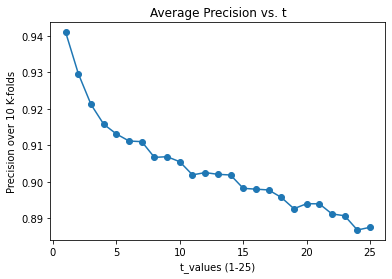

In [15]:
###########################
## MF-Bias Precision Plot #
###########################
print("Average Precision over 10-Folds:")
for prec in range(len(svdPrecisionList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(svdPrecisionList[prec]))

t_value = range(1,26)
plt.plot(t_value, svdPrecisionList, marker='o')
plt.title("Average Precision vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision over 10 K-folds")

Average Recall over 10-Folds:
Threshold: 1/25: 0.20452537248230165
Threshold: 2/25: 0.33682210798003875
Threshold: 3/25: 0.40982111978430497
Threshold: 4/25: 0.4475403475968843
Threshold: 5/25: 0.4657975795100297
Threshold: 6/25: 0.47956352874593866
Threshold: 7/25: 0.4953801477406655
Threshold: 8/25: 0.5062108030513464
Threshold: 9/25: 0.5191185914850255
Threshold: 10/25: 0.5330356818728085
Threshold: 11/25: 0.5472306459502376
Threshold: 12/25: 0.5484181034648848
Threshold: 13/25: 0.5570519310162323
Threshold: 14/25: 0.5638361627939691
Threshold: 15/25: 0.5721136600118297
Threshold: 16/25: 0.5719001772400338
Threshold: 17/25: 0.5842983794297616
Threshold: 18/25: 0.5891535686017169
Threshold: 19/25: 0.5870382491269428
Threshold: 20/25: 0.5952721672692951
Threshold: 21/25: 0.5976726691761163
Threshold: 22/25: 0.5993498603741249
Threshold: 23/25: 0.6077684440195744
Threshold: 24/25: 0.6163678044832004
Threshold: 25/25: 0.6162670541335646


Text(0, 0.5, 'Recall over 10 K-folds')

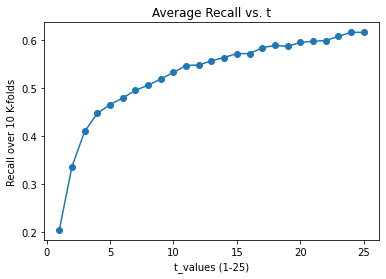

In [16]:
###########################
## MF-Bias Precision Plot #
###########################
print("Average Recall over 10-Folds:")
for prec in range(len(svdRecallList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(svdRecallList[prec]))

t_value = range(1,26)
plt.plot(t_value, svdRecallList, marker='o')
plt.title("Average Recall vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")

MF-Bias Precision vs. Recall over 10-Folds:


Text(0, 0.5, 'Precision')

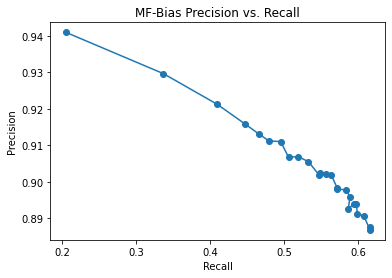

In [17]:
##################################
## MF-Bias Prceision vs. Recall Plot #
##################################
print("MF-Bias Precision vs. Recall over 10-Folds:")

t_value = range(1,26)
plt.plot(svdRecallList, svdPrecisionList, marker='o')
plt.title("MF-Bias Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Question 39

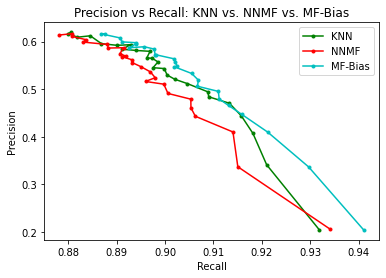

In [21]:
#############################################
## Plot All 3  Models: Precision vs. Recall #
#############################################
plt.plot(knnRecallList, knnPrecisionList, color='g', marker='o', markersize=3, label='KNN')
plt.plot(nmfRecallList, nmfPrecisionList, color='r', marker='o',  markersize=3, label='NNMF')
plt.plot(svdRecallList, svdPrecisionList, color='c', marker='o',  markersize=3, label='MF-Bias')
plt.title("Precision vs Recall: KNN vs. NNMF vs. MF-Bias")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

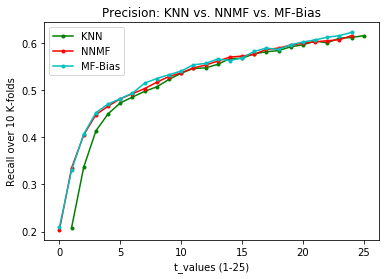

In [19]:
###############################
## Plot All 3  Models: Recall #
###############################
t_value = range(1,26)
plt.plot(t_value, knnRecallList, color='g', marker='o', markersize=3, label='KNN')
plt.plot(nmfRecallList, color='r', marker='o', markersize=3, label='NNMF')
plt.plot(svdRecallList, color='c', marker='o', markersize=3, label='MF-Bias')
plt.title("Precision: KNN vs. NNMF vs. MF-Bias")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")
plt.legend()

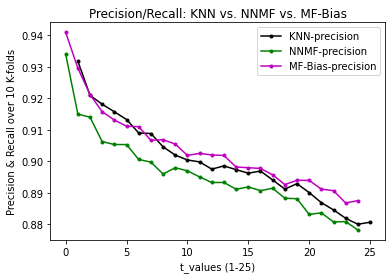

In [20]:
##################################
## Plot All 3  Models: Precision ##
##################################
t_value = range(1,26)
plt.plot(t_value, knnPrecisionList, color='k', marker='o', markersize=3, label='KNN-precision')
plt.plot(nmfPrecisionList, color='g', marker='o',  markersize=3, label='NNMF-precision')
plt.plot(svdPrecisionList, color='m', marker='o',  markersize=3, label='MF-Bias-precision')
plt.title("Precision/Recall: KNN vs. NNMF vs. MF-Bias")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision & Recall over 10 K-folds")
plt.legend()